In [98]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import data_reader
import matplotlib.patches as mpatches
import os
import matplotlib.lines as mlines
import random
from matplotlib import rcParams
from scipy.stats import linregress

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
rcParams["savefig.format"] = 'eps'
rcParams["savefig.dpi"] = 300

model_output_path = '../output/csv/'

with open('figure_path.txt') as f:
    figure_path = f.read()

with open('data_path.txt') as f:
    data_path = f.read()

dr = data_reader.DataReader()
choices, dynamics = dr.get_data(path=os.path.join(data_path, 'processed'), rename_vars=True)

# Figure 2

In [155]:
def get_screen_params():
    return {'x_lim':[-960-10, 960+10],
            'y_lim':[0-10, 1080+10],
            'left_resp_area_center':[-(960-150), (1080-170)],
            'right_resp_area_center':[(960-150), (1080-170)],
            'resp_area_radius':90}

def plot_traj_xy(ax, trajectory):
    p = get_screen_params()
    ax.set_aspect('equal')
    ax.set_xlim(p['x_lim'])
    ax.set_ylim(p['y_lim'])
    left_resp_area = plt.Circle(p['left_resp_area_center'], p['resp_area_radius'], 
                                facecolor='#ff9999', edgecolor='white')
    right_resp_area = plt.Circle(p['right_resp_area_center'], p['resp_area_radius'], 
                                 facecolor='#99ff99', edgecolor='white')
    ax.add_artist(left_resp_area)
    ax.add_artist(right_resp_area)
    
    ax.plot(trajectory.mouse_x[::4], trajectory.mouse_y[::4], #marker='o', markersize=7, 
            alpha=0.6, color='grey', lw=5)
    ax.set_xticks((-1000, -500, 0, 500, 1000))
    ax.set_yticks((0, 500, 1000))
    ax.tick_params(axis='both', labelsize=18)

def plot_trajectories_xy(exp_non_com_traj, exp_com_traj):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey='row')

    plot_traj_xy(ax1, exp_non_com_traj)
    plot_traj_xy(ax2, exp_com_traj)

    label_font_size = 24

    ax1.set_xlabel('x position (px)', fontsize=label_font_size)
    ax1.set_ylabel('y position (px)', fontsize=label_font_size)
    ax1.set_title('non-CoM')

    ax2.set_xlabel('x position (px)', fontsize=label_font_size)   
    ax2.set_title('CoM')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

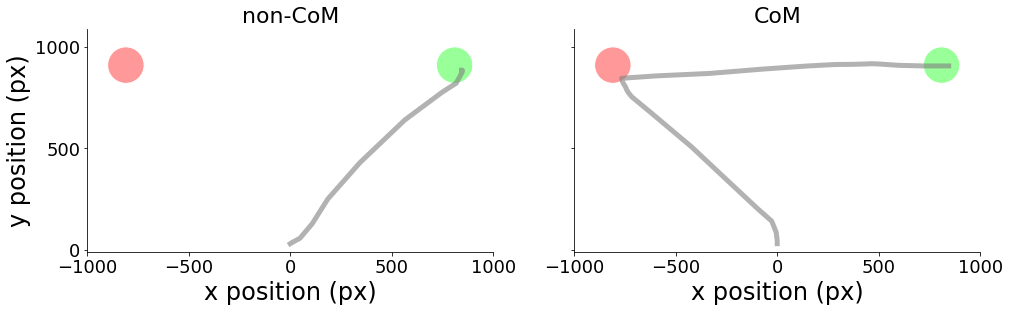

In [156]:
plot_trajectories_xy(exp_non_com_traj=dynamics.loc[(391, 2, 10, 39)], exp_com_traj=dynamics.loc[(391, 3, 6, 17)])
plt.savefig(os.path.join(figure_path, 'trajectories_xy') , bbox_inches='tight')

# Figure 3

### (a) Psychometric function

In [9]:
def get_psf_ci(c, n_threshold=0):
    # c is a choices dataframe
    # psf is a psychometric function
    # ci is a dataframe with confidence intervals for probability per coherence
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.type==t)]) / 
                   len(c[(c.coherence==coherence) & (c.type==t)]) 
               if len(c[(c.coherence==coherence) & (c.type==t)]) > n_threshold else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for t in np.sort(c.type.unique())])

    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.type.unique())], 
                                                         names=['coherence', 'type']))

    n = [len(c[(c.coherence==coherence) & (c.type==t)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for t in np.sort(c.type.unique())]

    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)

    return ci.reset_index()

def plot_psychometric_function(ax, choices, n_threshold=10):
    ci = get_psf_ci(choices[choices.coherence>0])
    sns.pointplot(data=ci, x='coherence', y='p_correct', hue='type', styles=['o', 'v'], 
                  scale=1, join=True, palette=['grey', 'black'], linestyles=['-', '-'], ax=ax)
    ax.vlines(x=range(0,5), ymin=ci[ci.type=='non-CoM'].ci_l, ymax=ci[ci.type=='non-CoM'].ci_r, 
                 color='black', zorder=10)    
    ax.vlines(x=range(0,5), ymin=ci[ci.type=='CoM'].ci_l, ymax=ci[ci.type=='CoM'].ci_r, 
                 color='grey', zorder=10)
    
    ax.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.4, 1.0, 7)))    
    ax.get_legend().set_title('')    
    ax.set_xlabel('')
    ax.set_ylabel('p(correct)')

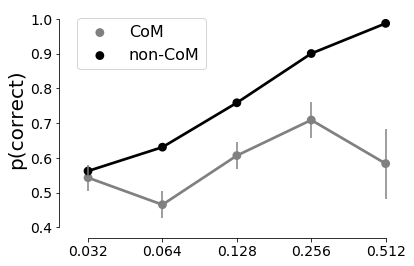

In [10]:
fig, ax = plt.subplots()
plot_psychometric_function(ax, choices)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'exp_p_correct') , bbox_inches='tight')

### (b) Probability of CoM

In [11]:
def get_ci_p_com(c, correct_col='is_correct', n_threshold=10):
    p_com = np.array([len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)])>n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c[correct_col].unique())])
    n = [len(c[(c.coherence==coherence) & (c[correct_col]==is_correct)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_correct in np.sort(c[correct_col].unique())]

    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c[correct_col].unique())], 
                                                         names=['coherence', correct_col]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def get_ci_p_com_total(c, n_threshold=10):
    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    
    ci = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])  
    
    p_com = ci.p_com
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def plot_p_com(ax, c):
    n_threshold = 0
    correct_col='is_correct'
    
    p_com_total = pd.DataFrame([(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
                               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
                               for coherence in np.sort(c.coherence.unique())], columns=['p_com', 'coherence'])
    
    sns.pointplot(data=p_com_total, x='coherence', y='p_com', scale=1.0, color='grey', join=True, ax=ax)
    
    p_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
             if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) > n_threshold) else 0  
             for coherence in np.sort(c.coherence.unique()) 
             for is_correct in np.sort(c[correct_col].unique())]
    
    p_com = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', correct_col]))
    # no correct/error labels for zero coherence
    p_com.loc[0] = np.NaN

    sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue=correct_col,
                       palette=['k', 'k'], linestyles=['--', '-'], scale=1.0, ax=ax, join = True)
    
    ci_total = get_ci_p_com_total(c, n_threshold=n_threshold)
    ax.vlines(x=range(0,6), ymin=ci_total.ci_l, ymax=ci_total.ci_r, color='grey', zorder=10)
    
    ci = get_ci_p_com(c, correct_col, n_threshold=n_threshold)
    ax.vlines(x=[val for pair in zip(range(1,6), range(1,6)) for val in pair], 
              ymin=ci[ci.coherence>0].ci_l, ymax=ci[ci.coherence>0].ci_r, color='black', zorder=10)

#     ax.set_ylim(-0.005, 0.06)
    ax.legend(handles=ax.lines[::len(choices.coherence.unique())+1],labels=['Total','Error','Correct'], frameon=True)
    ax.set_xlabel('')
    ax.set_ylabel('p(CoM)')

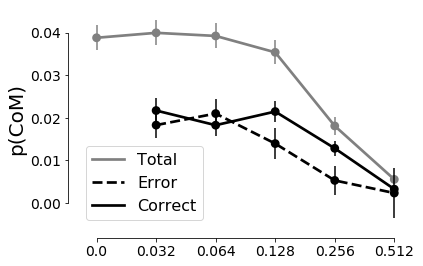

In [12]:
fig, ax = plt.subplots()
plot_p_com(ax, choices)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'exp_p_com_coh') , bbox_inches='tight')

### (c) Response time

In [13]:
def plot_rt(ax, choices):
#     choices = choices.drop(choices[(choices.coherence == 0.512) & (choices.is_com == True)].index)
    var = 'RT (z)'
    sns.pointplot(data=choices[(choices.coherence > 0) & (~choices.is_correct) & (choices.is_com == True)],
                       x='coherence', y=var, linestyles=['--'], color='grey', markers=['x'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == True)],
                       x='coherence', y=var, linestyles=['-'], color='grey', markers=['o'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.coherence < 0.512) & 
                               (~choices.is_correct) & (choices.is_com == False)],
                       x='coherence', y=var, linestyles=['--'], color='black', markers=['x'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)

    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == False)],
                       x='coherence', y=var, linestyles=['-'], color='black', markers=['o'], ci=68,
                       scale=1.0, errwidth=2, join=True, ax=ax)
    
    ax.legend(handles=ax.lines[::6], labels=['Error CoM', 'Correct CoM', 'Error non-CoM', 'Correct non-CoM'], 
                 fontsize=14, frameon=True)
    ax.set(ylim=(-2.0, 2.0))
    ax.set_ylabel('Response time (z)')

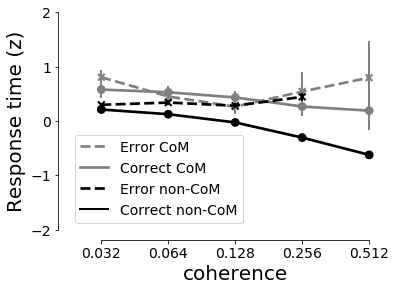

In [14]:
fig, ax = plt.subplots()
plot_rt(ax, choices)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'exp_rt_coh') , bbox_inches='tight')

### (d) Probability of CoM by RT tertile

In [159]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).size()
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    # This returns standard error of the mean
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_rt(ax, choices):
    ci = get_ci_vs_var(choices, 'RT (z) tertile', n_threshold=0)
    sns.pointplot(data=ci, x='coherence', y='p_com', hue='RT (z) tertile', palette='viridis_r', 
                  markers=['o', '^', 's'], ax=ax)
    ax.vlines(x=[val for pair in zip(range(0,6), range(0,6), range(0,6)) for val in pair], 
          ymin=ci.ci_l, ymax=ci.ci_r, color='gray', zorder=0)
    ax.set_ylabel('p(CoM)')
    ax.set_ylim(-0.005, 0.05)

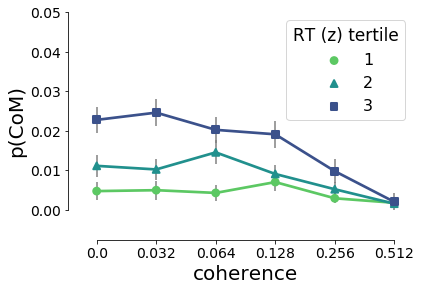

In [160]:
fig, ax = plt.subplots()
plot_p_com_vs_rt(ax, choices)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'exp_p_com_rt') , bbox_inches='tight')

### All panels

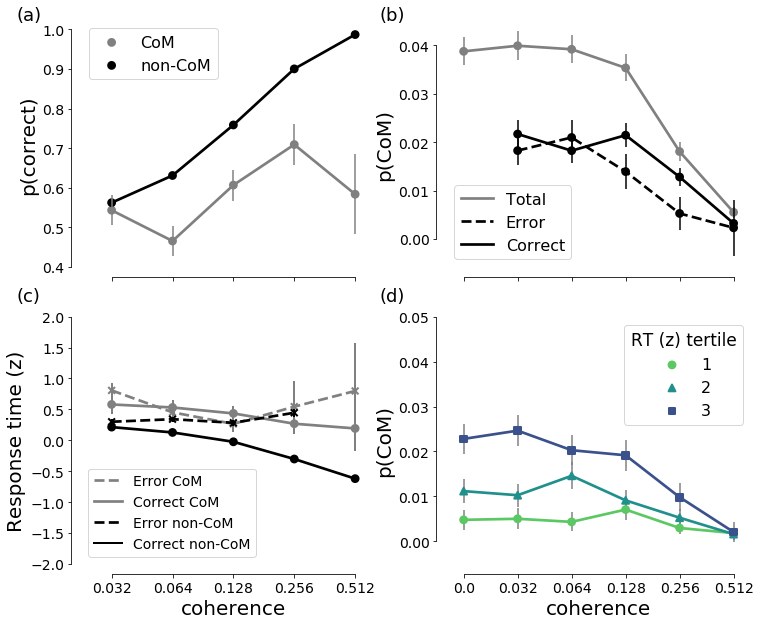

In [161]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex='col', sharey=False)

plot_psychometric_function(ax1, choices)
plot_p_com(ax2, choices)
plot_rt(ax3, choices)
plot_p_com_vs_rt(ax4, choices)
# plot_rt(ax1, choices)
# plot_psychometric_function(ax2, choices)
# plot_p_com(ax3, choices)
# plot_p_com_vs_rt(ax4, choices)

fig.text(0.05, 0.88, '(a)', fontsize=18)
fig.text(0.47, 0.88, '(b)', fontsize=18)
fig.text(0.05, 0.49, '(c)', fontsize=18)
fig.text(0.47, 0.49, '(d)', fontsize=18)

sns.despine(trim=True, offset=10)
plt.savefig(os.path.join(figure_path, 'exp_results') , bbox_inches='tight')

# Figure 5

In [151]:
def plot_response_areas(trajectory, ax):
    p = get_screen_params()
    
    y_error_l = (p['left_resp_area_center'][0]-p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    y_error_u = (p['left_resp_area_center'][0]+p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    
    ax.fill_between(trajectory.timestamp, y_error_l, y_error_u, facecolor='#ffcccc', edgecolor=None)
    
    y_correct_l = (p['right_resp_area_center'][0]-p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    y_correct_u = (p['right_resp_area_center'][0]+p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
        
    ax.fill_between(trajectory.timestamp, y_correct_l, y_correct_u, facecolor='#ccffcc', edgecolor=None)
    
def ms_to_s(traj):
    traj.timestamp = np.linspace(0,4000,4000)
    traj.timestamp = (traj.timestamp - traj.timestamp.min())/1000.0
    return traj

def resample_trajectory(traj, n_steps):
    # Make the sampling time intervals regular
    n = np.arange(0, n_steps + 1)
    t_regular = np.linspace(traj.timestamp.min(), traj.timestamp.max(), n_steps + 1)
    mouse_x_interp = np.interp(t_regular, traj.timestamp.values, traj.mouse_x.values)
    traj_interp = pd.DataFrame([n, t_regular, mouse_x_interp]).transpose()
    traj_interp.columns = ['n', 'timestamp', 'mouse_x']

    return traj_interp

def plot_traj_x_with_model(ax, exp_traj, model_traj):   
    ax.plot(exp_traj.timestamp[::4], exp_traj.mouse_x[::4], marker='o', markersize=7,
            alpha=0.6, label='Experiment', color='grey', lw=5)
    
    model_traj = resample_trajectory(ms_to_s(model_traj), n_steps=100)
    
    stop_point= model_traj.tail(1).index[0];
    ax.plot(model_traj.timestamp, model_traj.mouse_x, lw=5, markersize=7,
            alpha=0.6, label='Model', color='C0')
    
    plot_response_areas(exp_traj, ax)
    ax.set_ylim((-1100, 1100))
    ax.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5), frameon=False, fontsize=20)
    ax.tick_params(axis='both', labelsize=18)
    
def plot_trajectories_x(exp_non_com_traj, exp_com_traj, model_non_com_x_traj, model_com_x_traj):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey='row')

    plot_traj_x_with_model(ax1, exp_non_com_traj, model_non_com_x_traj)
    plot_traj_x_with_model(ax2, exp_com_traj, model_com_x_traj)

    label_font_size = 24

    ax1.set_title('non-CoM')
    ax2.set_title('CoM')

    ax1.set_xlim([0, exp_non_com_traj.timestamp.max()])
    ax1.set_xlabel('time (s)', fontsize=label_font_size)
    ax1.set_ylabel('x position (px)', fontsize=label_font_size)

    ax2.set_xlim([0, exp_com_traj.timestamp.max()])
    ax2.set_xlabel('time (s)', fontsize=label_font_size)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

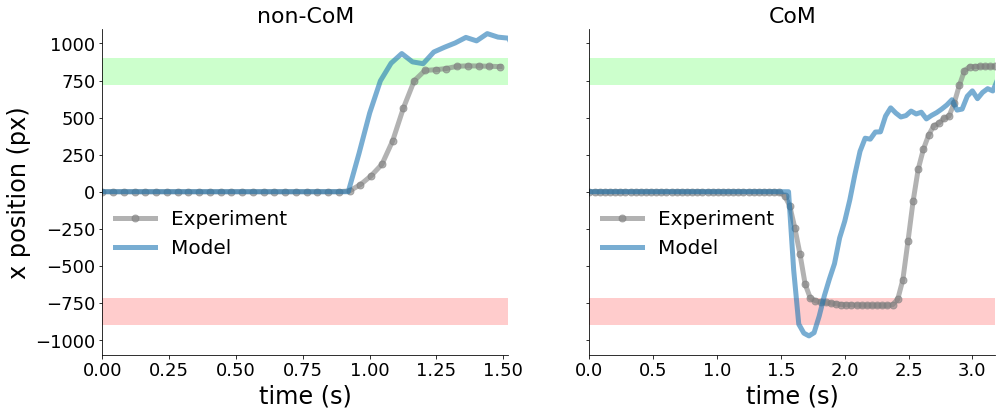

In [152]:
model_non_com_x_traj = pd.read_csv(os.path.join(model_output_path, 'x_traj_non_com.txt'), sep=',')
model_com_x_traj = pd.read_csv(os.path.join(model_output_path, 'x_traj_com.txt'), sep=',')
plot_trajectories_x(exp_non_com_traj=dynamics.loc[(391, 2, 10, 39)], exp_com_traj=dynamics.loc[(391, 3, 6, 17)],
                    model_non_com_x_traj=model_non_com_x_traj, model_com_x_traj=model_com_x_traj)
plt.savefig(os.path.join(figure_path, 'trajectories_x') , bbox_inches='tight')

# Figure 6

In [70]:
model_non_com_activity_traces= pd.read_csv(os.path.join(model_output_path, 'non_com_activity_traces.txt'), sep=',')
model_com_activity_traces = pd.read_csv(os.path.join(model_output_path, 'comactivity_traces.txt'), sep=',')

In [89]:
def plot_mean_timecourse(ax, activity_traces, activity_type, start, stop, 
                         step, step_multiplier, ticks): 
    times = np.linspace(0,4000,4000)
    
    plt.tight_layout()
    
    if (activity_type=='non-CoM'):
        sensorimotor_left_weak = activity_traces.y_1[::2].copy()
        sensorimotor_right_weak = activity_traces.y_2[::2].copy()
        sensorimotor_left_strong = activity_traces.y_1_25[::2].copy()
        sensorimotor_right_strong = activity_traces.y_2_25[::2].copy()

        uncertainty_weak = activity_traces.y_mc_hu[::2].copy()
        uncertainty_strong = activity_traces.y_mc_hu_25[::2].copy()

        hand_left_weak = activity_traces.y_5[::2].copy()
        hand_right_weak = activity_traces.y_6[::2].copy()
        hand_left_strong = activity_traces.y_5_25[::2].copy()
        hand_right_strong = activity_traces.y_6_25[::2].copy()
        motor_transform_strong = (hand_right_strong - hand_left_strong) * (760/37.5)
        motor_transform_weak = (hand_right_weak - hand_left_weak) * (760/37.5)
        
    elif (activity_type=='CoM'):
        sensorimotor_left_weak = activity_traces.y_1_25[::2].copy()
        sensorimotor_right_weak = activity_traces.y_2_25[::2].copy()
        
        uncertainty_weak = activity_traces.y_mc_hu_25[::2].copy()
        
        hand_left_weak = activity_traces.y_5_25[::2].copy()
        hand_right_weak = activity_traces.y_6_25[::2].copy()
        motor_transform_weak = (hand_right_weak - hand_left_weak) * (760/37.5)
        
    left_color = '#054793'
    right_color = '#F19259'
    uncertainty_color = '#F16675'
    
    linewidth = 2
    
    ax[0].set_title(activity_type)
    
    ax[0].plot(times[start:stop:step], sensorimotor_left_weak[start:stop:step], lw=linewidth,
                      label='Left, 0.032', color=left_color, linestyle='-')
    ax[0].plot(times[start:stop:step], sensorimotor_right_weak[start:stop:step], lw=linewidth,
                      label='Right, 0.032', color=right_color, linestyle='-')
    
    ax[1].plot(times[start:stop:step], uncertainty_weak[start:stop:step], lw=linewidth,
                      label= '0.032', color=uncertainty_color, linestyle='-')
    
    ax[2].plot(times[start:stop:step], hand_left_weak[start:stop:step], lw=linewidth,
               color=left_color, linestyle='-', label='Left, 0.032')
    ax[2].plot(times[start:stop:step], hand_right_weak[start:stop:step], lw=linewidth,
               color=right_color, linestyle='-', label='Right, 0.032')
        
    ax[3].plot(times[start:stop:step], motor_transform_weak[start:stop:step], lw=linewidth,
               color='black', linestyle='-')

    if (activity_type=='non-CoM'):
        ax[0].plot(times[start:stop:step], sensorimotor_left_strong[start:stop:step], lw=linewidth,
                          label='Left, 0.256', color=left_color, linestyle='--')
        ax[0].plot(times[start:stop:step], sensorimotor_right_strong[start:stop:step], lw=linewidth,
                          label='Right, 0.256', color=right_color,linestyle='--')
        ax[1].plot(times[start:stop:step], uncertainty_strong[start:stop:step], lw=linewidth,
                          label='0.256', color=uncertainty_color, linestyle='--')    
        ax[2].plot(times[start:stop:step], hand_left_strong[start:stop:step], lw=linewidth,
               color=left_color, linestyle='--', label='Left, 0.256')
        ax[2].plot(times[start:stop:step], hand_right_strong[start:stop:step], lw=linewidth,
               color=right_color, linestyle='--', label='Right, 0.256')
        ax[3].plot(times[start:stop:step], motor_transform_weak[start:stop:step], lw=linewidth,
               color='black', linestyle='-', label='Trajectory, 0.032')
        ax[3].plot(times[start:stop:step], motor_transform_strong[start:stop:step], lw=linewidth,
               color='grey', linestyle='--', label='Trajectory, 0.256')

    
    fig.text(0.5, -0.05, 'Time from stimulus onset (ms)', ha='center', fontsize=16)
    fig.text(-0.04, 0.6, 'Firing rate (Hz)', va='center', rotation='vertical', fontsize=16)
    fig.text(-0.04, 0.16, 'X position (px)', va='center', rotation='vertical', fontsize=16)
    
    for axes in ax:
        axes.legend().set_visible(False)
    return ax

No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002AE0C6DF668> has a label of '_line0' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


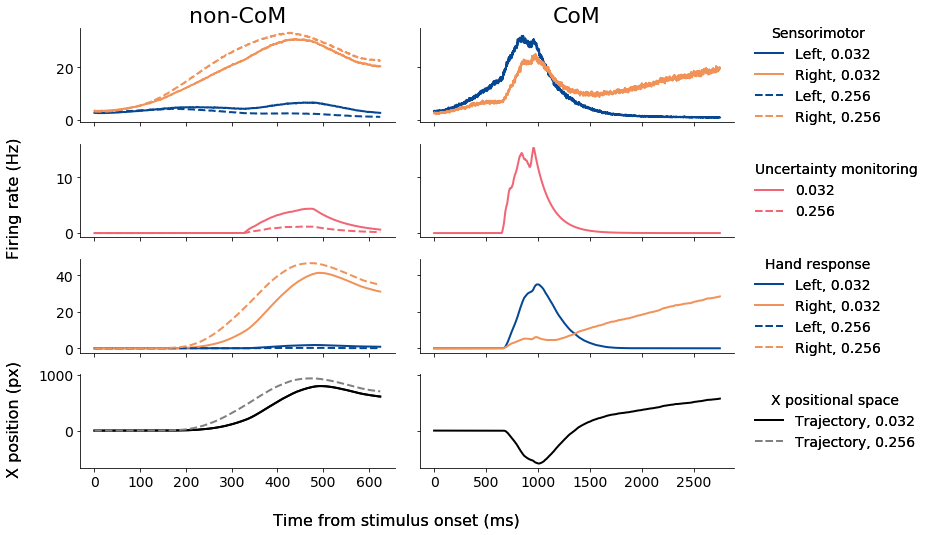

In [90]:
legend_properties = {'size': 14}
fig, axes = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(10,7))
axes_left = axes.T[0]
axes_right = axes.T[1]
plot_mean_timecourse(axes_left, model_non_com_activity_traces, 'non-CoM', start=650,
                     stop=1900, step=1, step_multiplier=200, ticks=np.arange(0, 1200, 100))

plot_mean_timecourse(axes_right, model_com_activity_traces, 'CoM', start=650,
                     stop=3400, step=1, step_multiplier=500, ticks=np.arange(0, 2860, 500))

lines_row_1 = axes_left[0].get_lines()
legend_1 = axes_right[0].legend(lines_row_1, [line.get_label() for line in lines_row_1],
                                loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, 
                                borderaxespad=0, frameon=False, prop=legend_properties)
legend_1.set_title('Sensorimotor', prop=legend_properties)

lines_row_2 = axes_left[1].get_lines()
legend_2 = axes_right[1].legend(lines_row_2, [line.get_label() for line in lines_row_2],
                                loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, 
                                borderaxespad=0, frameon=False, prop=legend_properties)
legend_2.set_title('Uncertainty monitoring', prop=legend_properties)
legend_2._legend_box.align = "left"

lines_row_3 = axes_left[2].get_lines()
legend_3 = axes_right[2].legend(lines_row_3, [line.get_label() for line in lines_row_3],
                                loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, 
                                borderaxespad=0, frameon=False, prop=legend_properties)
legend_3.set_title('Hand response', prop=legend_properties)

lines_row_4 = axes_left[3].get_lines()
legend_4 = axes_right[3].legend(lines_row_4, [line.get_label() for line in lines_row_4],
                                loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, 
                                borderaxespad=0, frameon=False, prop=legend_properties)
legend_4.set_title('X positional space', prop=legend_properties)

fig.add_artist(legend_1)
fig.add_artist(legend_2)
fig.add_artist(legend_3)
fig.add_artist(legend_4)

plt.sca(axes_left[3])
plt.xticks(np.arange(650,1900,1 * 200), np.arange(0, 1200, 100))
plt.sca(axes_right[3])
plt.xticks(np.arange(650,3400,1 * 500), np.arange(0, 2860, 500))

plt.savefig(os.path.join(figure_path, 'model_activity'), bbox_inches='tight')

# Figure 7

In [121]:
model_uncertainty_vs_coherence = pd.read_csv(os.path.join(model_output_path, 'uncertainty_vs_coherence.txt'), sep=',')
model_uncertainty_vs_RT = pd.read_csv(os.path.join(model_output_path, 'uncertainty_IT_correlation.txt'), sep=',')

model_uncertainty_vs_coherence /= 100
model_uncertainty_vs_coherence = model_uncertainty_vs_coherence.iloc[1:]

In [136]:
def plot_uncertainty_by_is_correct(ax, model_uncertainty_vs_coherence):        
    correct= ax.errorbar(x=range(5), y=model_uncertainty_vs_coherence.x_correct, yerr=model_uncertainty_vs_coherence.x_correct_sem,
                         color='C0', label='Correct', fmt='-o', marker='o', lw=2, markersize=10)
    error = ax.errorbar(x=range(5), y=model_uncertainty_vs_coherence.x_error, yerr=model_uncertainty_vs_coherence.x_error_sem,
                        color='C1', label='Error', fmt='--o', marker='x', lw=2, markersize=10)
    
    ax.legend(handles=[correct, error], frameon=True)
    ax.set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))
    ax.set_xlabel('Coherence')
    ax.set_ylabel('Uncertainty ' + r'$\upsilon$')
    
def plot_uncertainty_vs_RT(ax, model_uncertainty_vs_RT):
    X = model_uncertainty_vs_RT.uncertainty
    Y = model_uncertainty_vs_RT.IT
    
    ax.scatter(x=X, y=Y, color='C0', label= 'trials')
    fit = linregress(X, Y)
    ax.plot(X, fit.intercept + fit.slope*X, 'C1', label='linear fit')
    rvalue= fit.rvalue
    rvalue_string = f"{rvalue:.2f}"
    ax.set_title('$R^2$ = ' + rvalue_string)
    
    ax.set_xlabel('Uncertainty ' + r'$\upsilon$')
    ax.set_ylabel('Response time')
    
    ax.set_ylim((0.955, 1))
    
    plt.legend()

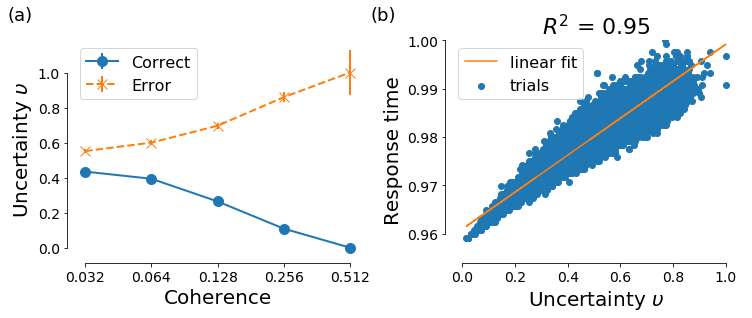

In [137]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

plot_uncertainty_by_is_correct(ax1, model_uncertainty_vs_coherence)
plot_uncertainty_vs_RT(ax2, model_uncertainty_vs_RT)

fig.text(0.05, 0.95, '(a)', fontsize=18)
fig.text(0.47, 0.95, '(b)', fontsize=18)

plt.subplots_adjust(wspace=0.3)
sns.despine(trim=True, offset=5)
plt.savefig(os.path.join(figure_path, 'model_signature_uncertainty'), bbox_inches='tight')

# Figure 8

In [23]:
model_psychometric_function_non_com= pd.read_csv(os.path.join(model_output_path, 'psychometric_function.txt'), sep=',')
model_psychometric_function_com= pd.read_csv(os.path.join(model_output_path, 'psychometric_function_com.txt'), sep=',')
model_rt_non_com= pd.read_csv(os.path.join(model_output_path, 'response_times_non_com.txt'), sep=',')
model_rt_com= pd.read_csv(os.path.join(model_output_path, 'response_times_com.txt'), sep=',')
model_p_com = pd.read_csv(os.path.join(model_output_path, 'p_com.txt'), sep=',')
model_p_com_tertiles= pd.read_csv(os.path.join(model_output_path, 'model_tertiles.txt'), sep=',')
model_noncom_x_trajectory=  pd.read_csv(os.path.join(model_output_path, 'x_traj_non_com.txt'), sep=',')
model_com_x_trajectory= pd.read_csv(os.path.join(model_output_path, 'x_traj_com.txt'), sep=',')
model_noncom_mean_trajectory= pd.read_csv(os.path.join(model_output_path, 'x_traj_non_com_mean.txt'), sep=',')
model_com_mean_trajectroy= pd.read_csv(os.path.join(model_output_path, 'x_traj_com_mean.txt'), sep=',')

model_choices = pd.read_csv(os.path.join(model_output_path, 'model_tertiles.txt'), sep=',')
model_choices = model_choices.rename(columns={'hand_IT': 'RT (z)'})
model_choices['coherence'] /= 100
model_choices['RT (z) tertile'] = pd.qcut(model_choices['RT (z)'], 3, labels=[1, 2, 3])
model_choices['is_com'] = model_choices['is_com'].astype('bool')
# Exclude response times from 51.2 com trials- number of trials too low.
model_rt_non_com.init_z_error.loc[5] = np.nan
model_rt_com.init_z_correct.loc[5] = np.nan
model_rt_com.init_z_error.loc[5] = np.nan

### (a) Psychometric function

In [24]:
def plot_psychometric_function_model(ax, psf_non_com, psf_com):
    ax.plot(range(4), psf_com.pcorrect_y_real.iloc[1:5], label='CoM', color='grey', marker='o', ls='-', ms=8, lw=2)
    ax.plot(range(5), psf_non_com.pcorrect_y_real.iloc[1:], label='non-CoM', color='black', marker='o', ls='-', ms=8, lw=2)
    ax.set_xticklabels(['0.032', '0.064', '0.128', '0.256', '0.512'])
    ax.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.4, 1.0, 7)))
    ax.set_xlabel('')
    ax.set_ylabel('p(correct)')
    ax.legend()

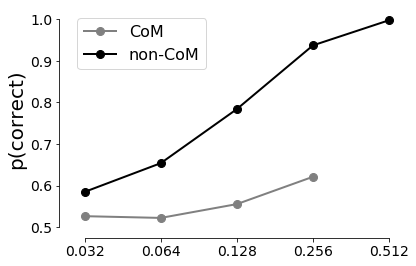

In [18]:
fig, ax = plt.subplots()
plot_psychometric_function_model(ax, model_psychometric_function_non_com, model_psychometric_function_com)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'model_p_correct') , bbox_inches='tight')

### (b) Probability of CoM

In [25]:
def plot_p_com_model(ax, model_p_com):
    model_p_com['p_com_correct'][0] = np.NaN
    model_p_com['pcom_incorrect'][0] = np.NaN
    
    ax.plot(range(6), model_p_com.p_com_all, marker = 'o', color='grey', label='Total',ls='-', ms=8, lw=2)
    ax.plot(range(6), model_p_com.p_com_correct, marker = 'o', color='black', label='Correct',ls='-', ms=8, lw=2)
    ax.plot(range(6), model_p_com.pcom_incorrect, marker = 'o',color='black', label='Error',ls='--', ms=8, lw=2)

    ax.set_xticklabels(('0.0', '0.032', '0.064', '0.128', '0.256', '0.512'))
    ax.set_ylim(-0.005, 0.06)
    ax.legend()
    ax.set_ylabel('p(CoM)')

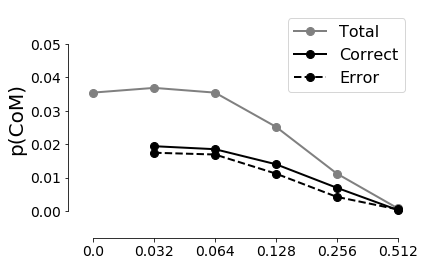

In [20]:
fig, ax = plt.subplots()
plot_p_com_model(ax, model_p_com)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'model_p_com') , bbox_inches='tight')

### (c) Response time

In [26]:
def plot_rt_model(ax, model_rt_non_com, model_rt_com):
    ax.errorbar(x=range(5), y=model_rt_com.init_z_correct[1::], yerr=model_rt_com.init_z_correct_sem[1::],
                 ls='-', fmt='-s',color='grey', label='Correct', marker='o', lw=2, ms=8)
    
    ax.errorbar(x=range(5), y=model_rt_com.init_z_error[1::], yerr=model_rt_com.init_z_error_sem[1::],
                 ls='--', fmt='-s', color='grey', label='Error', marker='x', lw=2, ms=8)
    
    ax.errorbar(x=range(5), y=model_rt_non_com.init_z_correct[1::], yerr=model_rt_non_com.init_z_correct_sem[1::],
                 ls='-', fmt='-s',color='black', label='Correct', marker='o', lw=2, ms=8)
    
    ax.errorbar(x=range(5), y=model_rt_non_com.init_z_error[1::], yerr=model_rt_non_com.init_z_error_sem[1::],
                 ls='--', fmt='-s', color='black', label='Error', marker='x', lw=2, ms=8)
    
    ax.set(ylim=(-2.0, 2.0))
    ax.set_xticks(range(5))
    ax.set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))   
    ax.set_xlabel('coherence')
    ax.set_ylabel('Response time (z)')
    ax.legend(labels=['Error CoM', 'Correct CoM', 'Error non-CoM', 'Correct non-CoM'], fontsize=16, frameon=True)

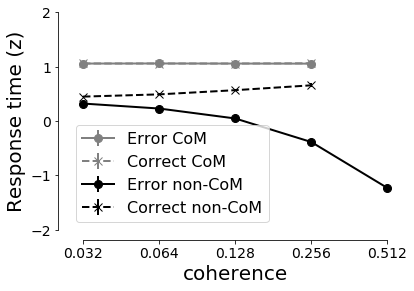

In [22]:
fig, ax = plt.subplots()
plot_rt_model(ax, model_rt_non_com, model_rt_com)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'model_rt_coh') , bbox_inches='tight')

### (d) Probability of CoM by RT tertile

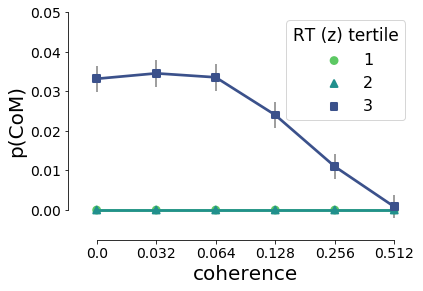

In [162]:
fig, ax = plt.subplots()
plot_p_com_vs_rt(ax, model_choices)
sns.despine(trim=True, offset=10)
# plt.savefig(os.path.join(figure_path, 'model_p_com_rt') , bbox_inches='tight')

### All panels

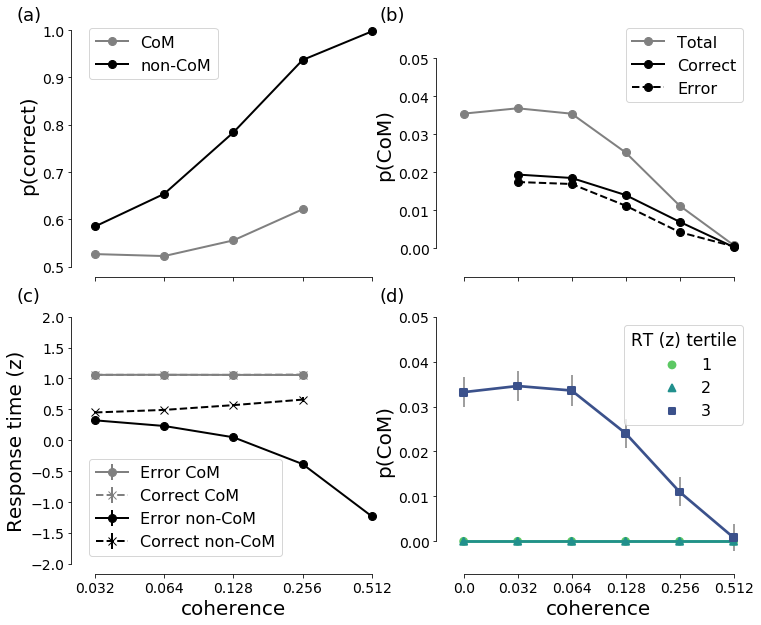

In [163]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex='col', sharey=False)

plot_psychometric_function_model(ax1, model_psychometric_function_non_com, model_psychometric_function_com)
plot_p_com_model(ax2, model_p_com)
plot_rt_model(ax3, model_rt_non_com, model_rt_com)
plot_p_com_vs_rt(ax4, model_choices)

fig.text(0.05, 0.88, '(a)', fontsize=18)
fig.text(0.47, 0.88, '(b)', fontsize=18)
fig.text(0.05, 0.49, '(c)', fontsize=18)
fig.text(0.47, 0.49, '(d)', fontsize=18)

sns.despine(trim=True, offset=10)
plt.savefig(os.path.join(figure_path, 'model_results') , bbox_inches='tight')

# Figure 9

In [48]:
model_uncertainty_vs_coherence_com = pd.read_csv(os.path.join(model_output_path, 'uncertainty_vs_coherence_com.txt'), sep=',')
model_uncertainty_tertiles = pd.read_csv(os.path.join(model_output_path, 'model_tertiles_uncertainty.txt'), sep=',')

model_uncertainty_tertiles.coherence /= 100
model_uncertainty_vs_coherence_com /= 100

(a)

In [49]:
def plot_uncertainty(ax, uncertainty, var):        
    correct = ax.errorbar(x=range(5), y=uncertainty.x_correct, yerr=uncertainty.x_correct_sem,
                         color='grey', label='CoM', fmt='-o', marker='o', markersize=10)
    error = ax.errorbar(x=range(5), y=uncertainty.x_error, yerr=uncertainty.x_error_sem,
                        color='black', label='non-CoM', fmt='-o', marker='o', markersize=10)
    
    ax.legend(handles=[correct, error], frameon=True)
    ax.set_xlabel('coherence')
    ax.set_ylabel('uncertainty ' + r'$\upsilon$')
    ax.set_xticklabels(('0', '0.032', '0.064', '0.128', '0.256'))
    sns.despine(ax=ax, trim=True, offset=5)

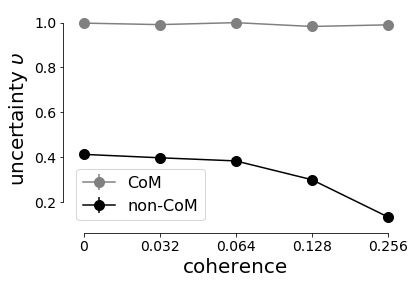

In [50]:
fig, ax = plt.subplots()
plot_uncertainty(ax, model_uncertainty_vs_coherence_com, 'com')
# plt.savefig(os.path.join(figure_path, 'uncertainty_vs_com'), bbox_inches='tight')

(b)

In [164]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).apply(len)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(ax, data, var, title, palette='viridis_r', n_threshold=0):   
    ci = get_ci_vs_var(data, var, n_threshold=n_threshold)

    sns.pointplot(ax=ax, data=ci, x='coherence', y='p_com', hue=var, palette=palette, markers=['o', '^', 's'])
    
    ax.legend(fontsize=14, title_fontsize=13, title='Uncertainty tertile')  
    
    ax.set_ylim(-0.005, 0.05)
    ax.set_ylabel('p(CoM)')
    sns.despine(ax=ax, trim=True, offset=5)

    return ax

In [56]:
# pd.qcut assumes equal bin sizes- workaround in this function below:
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).idxmax()
    return series.rank(pct=1).apply(f)

model_uncertainty_tertiles['uncertainty_tertile'] = pct_rank_qcut(model_uncertainty_tertiles['uncertainty'], 3)
model_uncertainty_tertiles['is_com'] = model_uncertainty_tertiles['is_com'].astype('bool')

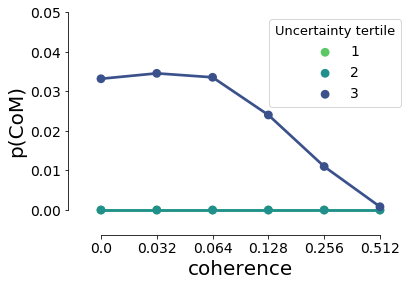

In [68]:
fig, ax = plt.subplots()
plot_p_com_vs_var_ci(ax, model_uncertainty_tertiles, 'uncertainty_tertile', 'Model', n_threshold=10)
# plt.savefig(os.path.join(figure_path, 'uncertainty_tertile_model'), bbox_inches='tight')

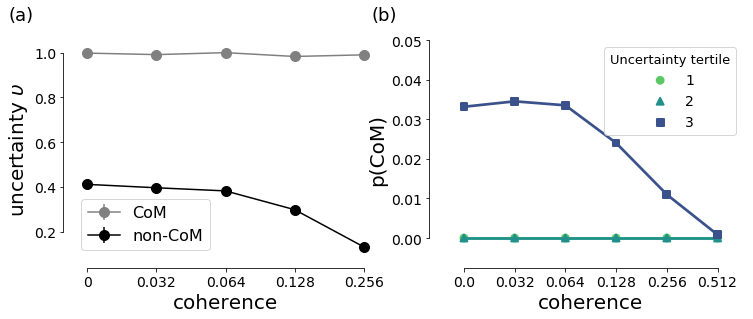

In [166]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

plot_uncertainty(ax1, model_uncertainty_vs_coherence_com, 'com')
plot_p_com_vs_var_ci(ax2, model_uncertainty_tertiles, 'uncertainty_tertile', 'Model', n_threshold=10)

fig.text(0.05, 0.95, '(a)', fontsize=18)
fig.text(0.47, 0.95, '(b)', fontsize=18)

sns.despine(trim=True, offset=10)
plt.savefig(os.path.join(figure_path, 'model_uncertainty_results') , bbox_inches='tight')